In [1]:
import pysam 
import pandas as pd
import sys
sys.path.append("./scripts")
import utils
import seaborn as sns
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pysam'

In [2]:
df = pd.read_csv("/Users/zluo/TestData/GENCODE/GRCh38/gencode.v31.primary_assembly.protein_coding.exon.srt.bed",sep='\t', names=['chrom','start','end','name','score','strand'])

In [4]:
fa = pysam.FastaFile("/Users/zluo/TestData/GENCODE/GRCh38/Sequence/GRCh38.p13.genome.fa")

In [5]:
gtf_gene, gtf_ts, gtf_exon, gtf_CDS = utils.parse_gtf("../TestData/GENCODE/GRCh38/Annotation/gencode.v31.primary_assembly.annotation.gtf")

Dask Apply: 100%|██████████| 24/24 [16:25<00:00, 41.08s/it]


In [7]:
gtf_gene.to_csv('../TestData/GENCODE/GRCh38/Annotation/gencode.v31.primary_assembly.annotation.gene.tab',sep='\t',index=False)
gtf_ts.to_csv('../TestData/GENCODE/GRCh38/Annotation/gencode.v31.primary_assembly.annotation.ts.tab',sep='\t',index=False)
gtf_exon.to_csv('../TestData/GENCODE/GRCh38/Annotation/gencode.v31.primary_assembly.annotation.exon.tab',sep='\t',index=False)
gtf_CDS.to_csv('../TestData/GENCODE/GRCh38/Annotation/gencode.v31.primary_assembly.annotation.CDS.tab',sep='\t',index=False)

In [11]:
gtf_gene = pd.read_csv('../TestData/GENCODE/GRCh38/Annotation/gencode.v31.primary_assembly.annotation.gene.tab',sep='\t')
gtf_ts = pd.read_csv('../TestData/GENCODE/GRCh38/Annotation/gencode.v31.primary_assembly.annotation.ts.tab',sep='\t', dtype={'transcript_support_level':str})
gtf_exon = pd.read_csv('../TestData/GENCODE/GRCh38/Annotation/gencode.v31.primary_assembly.annotation.exon.tab',sep='\t')
gtf_CDS = pd.read_csv('../TestData/GENCODE/GRCh38/Annotation/gencode.v31.primary_assembly.annotation.CDS.tab',sep='\t')

In [12]:
# assign cds to transcripts
gtf_ts = utils.assign_cds_to_ts(gtf_ts, gtf_CDS)
gtf_ts.to_csv('../TestData/GENCODE/GRCh38/Annotation/gencode.v31.primary_assembly.annotation.ts.tab',sep='\t',index=False)

In [5]:
gtf_gene_coding = gtf_gene[gtf_gene['gene_type'] == 'protein_coding']
gtf_ts_coding = gtf_ts[gtf_ts['gene_id'].isin(gtf_gene_coding['gene_id'])]
gtf_ts_coding_tsl1and2 = gtf_ts_coding[gtf_ts_coding['transcript_support_level'].isin(['1','2',1,2])]
gtf_exon_coding_tsl1and2 = gtf_exon[gtf_exon['transcript_id'].isin(gtf_ts_coding_tsl1and2['transcript_id'])]

In [15]:
gtf_gene_coding
gtf_ts_coding_tsl1and2_sample = gtf_ts_coding_tsl1and2.sample(n=1000, random_state=1992)
with open('/Users/zluo/TestData/GENCODE/GRCh38/gtf_ts_coding_tsl1and2_sample1000_intron.bed', 'w') as intron_bed:
    for idx, row in gtf_ts_coding_tsl1and2_sample.iterrows():
        ts_id = row['transcript_id']
        exons  = gtf_exon_coding_tsl1and2[gtf_exon_coding_tsl1and2['transcript_id'] == ts_id]
        exons = exons.sort_values('exon_number')
        exon_cnt = exons['exon_number'].max()
        if exon_cnt < 2:
            continue
        for idx_exon, exon in exons.iterrows():
            exon_number = exon['exon_number']
            if exon_number == 1:
                exon_end = int(exon['end'])
                continue
            else:
                exon_start = int(exon['start'])
                intron_start = exon_end
                intron_end = exon_start
                exon_end = int(exon['end'])
            intron_chrom = exon['seqname']
            intron_name = '{}:{}:{}'.format(exon['gene_name'],exon['transcript_id'],exon_number-1)
            intron_score = row['transcript_support_level']
            intron_strand = exon['strand']
            intron_bed.write('{}\t{}\t{}\t{}\t{}\t{}\n'.format(intron_chrom, intron_start, intron_end, intron_name, int(intron_score), intron_strand))

In [65]:
def get_alt_exons(gtf_ts, gtf_exon):

    gtf_exon = gtf_exon.to_dict('index')
    gtf_ts = gtf_ts.to_dict('index')
    gene_ts_cnt = dict()
    exon_usage = dict()
    ts_exon_dict = dict()
    for idx in gtf_exon:
        transcript_id = gtf_exon[idx]['transcript_id']
        if transcript_id not in ts_exon_dict:
            ts_exon_dict[transcript_id] = list()
        ts_exon_dict[transcript_id].append(idx)
    
    for idx in gtf_ts:
        gene_id = gtf_ts[idx]['gene_id']
        if gene_id not in gene_ts_cnt:
            gene_ts_cnt[gene_id] = 0
        gene_ts_cnt[gene_id] += 1
    
    for transcript_id in ts_exon_dict:
        exon_set = sorted(ts_exon_dict[transcript_id])
        exon_num = len(exon_set)
        for i, exon_idx in enumerate(exon_set):
            if i == 0 or i == exon_num - 1:
                continue

            gene_id = gtf_exon[exon_idx]['gene_id']
            exon_id = gtf_exon[exon_idx]['seqname'] + str(gtf_exon[exon_idx]['start']) + str(gtf_exon[exon_idx]['end']) + gtf_exon[exon_idx]['strand']
            if exon_id not in exon_usage:
                exon_usage[exon_id] = 0
            exon_usage[exon_id] += 1
    alt_exon_idx = list()
    alt_exon_coord = set()
    
    for idx in gtf_exon:
        exon_id = gtf_exon[idx]['seqname'] + str(gtf_exon[idx]['start']) + str(gtf_exon[idx]['end']) + gtf_exon[idx]['strand']
        gene_id = gtf_exon[idx]['gene_id']
        if exon_id in exon_usage and gene_id in gene_ts_cnt:
            if exon_usage[exon_id] != gene_ts_cnt[gene_id]:
                if exon_id not in alt_exon_coord:
                    alt_exon_idx.append(idx)
                    alt_exon_coord.add(exon_id)
                
    return alt_exon_idx

In [66]:
exon_idx_list = get_alt_exons(gtf_ts_coding_tsl1and2, gtf_exon)
gtf_exon_dict = gtf_exon.to_dict('index')

with open('/Users/zluo/TestData/GENCODE/GRCh38/gencode.v31.primary_assembly.coding.alt.exon.bed', 'w') as alt_exon:
    for idx in exon_idx_list:
        exon = gtf_exon_dict[idx]
        # gtf coordinates are 1-based, remember to covert to 0-based.
        alt_exon.write('{}\t{}\t{}\t{}\t{}\t{}\n'.format(exon['seqname'], exon['start']-1  , exon['end'], exon['exon_id'], '.', exon['strand']))

In [2]:
gtf_ts = pd.read_csv("/Users/zluo/TestData/GENCODE/GRCh38/Annotation/gencode.v31.primary_assembly.annotation.ts.tab", sep='\t')
gtf_cds = pd.read_csv("/Users/zluo/TestData/GENCODE/GRCh38/Annotation/gencode.v31.primary_assembly.annotation.CDS.tab",sep='\t')
gtf_cds.head()

gtf_ts = gtf_ts.to_dict('index')
gtf_cds = gtf_cds.to_dict('index')

gtf_ts_cds_dict = utils.build_ts_dict(gtf_cds)

,seqname,source,feature,start,end,score,strand,frame,attribute,gene_id,gene_type,gene_name,transcript_id,exon_id,exon_number
0,chr1,HAVANA,CDS,65565,65573,.,+,0,"gene_id ""ENSG00000186092.6""; transcript_id ""EN...",ENSG00000186092.6,protein_coding,OR4F5,ENST00000641515.2,ENSE00003813641.1,2
1,chr1,HAVANA,CDS,69037,70005,.,+,0,"gene_id ""ENSG00000186092.6""; transcript_id ""EN...",ENSG00000186092.6,protein_coding,OR4F5,ENST00000641515.2,ENSE00003813949.1,3
2,chr1,ENSEMBL,CDS,69091,70005,.,+,0,"gene_id ""ENSG00000186092.6""; transcript_id ""EN...",ENSG00000186092.6,protein_coding,OR4F5,ENST00000335137.4,ENSE00002319515.2,1
3,chr1,HAVANA,CDS,450743,451678,.,-,0,"gene_id ""ENSG00000284733.1""; transcript_id ""EN...",ENSG00000284733.1,protein_coding,OR4F29,ENST00000426406.3,ENSE00002316283.3,1
4,chr1,HAVANA,CDS,685719,686654,.,-,0,"gene_id ""ENSG00000284662.1""; transcript_id ""EN...",ENSG00000284662.1,protein_coding,OR4F16,ENST00000332831.4,ENSE00002324228.3,1


In [5]:
fa.fetch('chr1',69090,70005)

'ATGGTGACTGAATTCATTTTTCTGGGTCTCTCTGATTCTCAGGAACTCCAGACCTTCCTATTTATGTTGTTTTTTGTATTCTATGGAGGAATCGTGTTTGGAAACCTTCTTATTGTCATAACAGTGGTATCTGACTCCCACCTTCACTCTCCCATGTACTTCCTGCTAGCCAACCTCTCACTCATTGATCTGTCTCTGTCTTCAGTCACAGCCCCCAAGATGATTACTGACTTTTTCAGCCAGCGCAAAGTCATCTCTTTCAAGGGCTGCCTTGTTCAGATATTTCTCCTTCACTTCTTTGGTGGGAGTGAGATGGTGATCCTCATAGCCATGGGCTTTGACAGATATATAGCAATATGCAAGCCCCTACACTACACTACAATTATGTGTGGCAACGCATGTGTCGGCATTATGGCTGTCACATGGGGAATTGGCTTTCTCCATTCGGTGAGCCAGTTGGCGTTTGCCGTGCACTTACTCTTCTGTGGTCCCAATGAGGTCGATAGTTTTTATTGTGACCTTCCTAGGGTAATCAAACTTGCCTGTACAGATACCTACAGGCTAGATATTATGGTCATTGCTAACAGTGGTGTGCTCACTGTGTGTTCTTTTGTTCTTCTAATCATCTCATACACTATCATCCTAATGACCATCCAGCATCGCCCTTTAGATAAGTCGTCCAAAGCTCTGTCCACTTTGACTGCTCACATTACAGTAGTTCTTTTGTTCTTTGGACCATGTGTCTTTATTTATGCCTGGCCATTCCCCATCAAGTCATTAGATAAATTCCTTGCTGTATTTTATTCTGTGATCACCCCTCTCTTGAACCCAATTATATACACACTGAGGAACAAAGACATGAAGACGGCAATAAGACAGCTGAGAAAATGGGATGCACATTCTAGTGTAAAGTTT'

In [13]:
# get codon table
seq = utils.concat_interval_seq('ENST00000335137.4',gtf_ts_cds_dict,gtf_cds, fa)

In [18]:
codon_stat = dict()
codon_table = dict()
with open("/Users/zluo/sequtils/standard_codon_table.txt") as codon_table_file:
    codon_table_file.readline()
    for line in codon_table_file:
        codon, symbol_s, symbol, name = line.rstrip().split('\t')
        codon_stat[codon] = 0
        codon_table[codon] = symbol

'codon\tsymbol_s\tsymbol\tname\n'

In [38]:
cds_ts_set = pd.read_csv("/Users/zluo/TestData/GENCODE/GRCh38/Annotation/gencode.v31.primary_assembly.annotation.CDS.tab",sep='\t')['transcript_id'].unique()
def reverse_complement(seq):
    # return reverse complementary sequence of input
    try:
        assert set(seq).issubset(set("ACGTN"))
    except AssertionError:
        raise ValueError(
            "Sequence {} contains invalid values: {}"
            .format(seq, set(seq) - set('ACGTN'))
        )
    return ''.join('TGCAN'['ACGTN'.index(s)] for s in seq.upper()[::-1])

def concat_interval_seq(ts_id, ts_dict, interval_set, genome_seq):
    concat_seq = ''
    strand = '+'
    print(ts_dict[ts_id])
    for interval_id in ts_dict[ts_id]:
        chrom = interval_set[interval_id]['seqname']
        if interval_set[interval_id]['strand'] == '-':
            strand = '-'
        start = int(interval_set[interval_id]['start'])
        start = start - 1
        end = int(interval_set[interval_id]['end'])
        concat_seq = concat_seq + genome_seq.fetch(chrom,start,end)
    if strand == '-':
        return reverse_complement(concat_seq)
    return concat_seq
for ts_id in cds_ts_set:
    seq = concat_interval_seq(ts_id,gtf_ts_cds_dict,gtf_cds, fa)
    print(ts_id)
    print(seq)
    for i in range(0,len(seq),3):
        codon_stat[seq[i:i+3]] +=1
        
codon_stat

[0, 1]
ENST00000641515.2
ATGAAGAAGGTAACTGCAGAGGCTATTTCCTGGAATGAATCAACGAGTGAAACGAATAACTCTATGGTGACTGAATTCATTTTTCTGGGTCTCTCTGATTCTCAGGAACTCCAGACCTTCCTATTTATGTTGTTTTTTGTATTCTATGGAGGAATCGTGTTTGGAAACCTTCTTATTGTCATAACAGTGGTATCTGACTCCCACCTTCACTCTCCCATGTACTTCCTGCTAGCCAACCTCTCACTCATTGATCTGTCTCTGTCTTCAGTCACAGCCCCCAAGATGATTACTGACTTTTTCAGCCAGCGCAAAGTCATCTCTTTCAAGGGCTGCCTTGTTCAGATATTTCTCCTTCACTTCTTTGGTGGGAGTGAGATGGTGATCCTCATAGCCATGGGCTTTGACAGATATATAGCAATATGCAAGCCCCTACACTACACTACAATTATGTGTGGCAACGCATGTGTCGGCATTATGGCTGTCACATGGGGAATTGGCTTTCTCCATTCGGTGAGCCAGTTGGCGTTTGCCGTGCACTTACTCTTCTGTGGTCCCAATGAGGTCGATAGTTTTTATTGTGACCTTCCTAGGGTAATCAAACTTGCCTGTACAGATACCTACAGGCTAGATATTATGGTCATTGCTAACAGTGGTGTGCTCACTGTGTGTTCTTTTGTTCTTCTAATCATCTCATACACTATCATCCTAATGACCATCCAGCATCGCCCTTTAGATAAGTCGTCCAAAGCTCTGTCCACTTTGACTGCTCACATTACAGTAGTTCTTTTGTTCTTTGGACCATGTGTCTTTATTTATGCCTGGCCATTCCCCATCAAGTCATTAGATAAATTCCTTGCTGTATTTTATTCTGTGATCACCCCTCTCTTGAACCCAATTATATACACACTGAGGAACAAAGACATGAAGACGGCAATAAGACAGCTGAGAAAATGGGATGCACATTCTAGTGTAAAG

KeyError: 'GT'

In [76]:
def get_introns(gtf_ts, gtf_exon):
    gtf_ts = gtf_ts.to_dict('index')
    gtf_exon = gtf_exon.to_dict('index')
    ts_exon_dict = dict()
    for idx in gtf_exon:
        transcript_id = gtf_exon[idx]['transcript_id']
        if transcript_id not in ts_exon_dict:
            ts_exon_dict[transcript_id] = list()
        ts_exon_dict[transcript_id].append(idx)
    
    for ts_idx in gtf_ts:
        transcript_id = gtf_ts[ts_idx]['transcript_id']
        exon_set = sorted(ts_exon_dict[transcript_id])
        exon_num = len(exon_set)
        if exon_num < 2:
            continue
        intron_chrom = gtf_ts[ts_idx]['seqname']
        intron_strand = gtf_ts[ts_idx]['strand']
        intron_start = 0
        intron_end = 0
        for i, exon_idx in enumerate(exon_set):
            if i == 0:
                if intron_strand == '+':
                    intron_start = gtf_exon[exon_idx]['end']
                else:
                    intron_end = gtf_exon[exon_idx]['start']
            else:
                if intron_strand == '+':
                    intron_end = gtf_exon[exon_idx]['start']
                else:
                    intron_start = gtf_exon[exon_idx]['end']
                intron_name = transcript_id+'_'+str(i)
                yield '{}\t{}\t{}\t{}\t{}\t{}\n'.format(intron_chrom, intron_start, intron_end, intron_name, '.', intron_strand)
                if intron_strand == '+':
                    intron_start = gtf_exon[exon_idx]['end']
                else:
                    intron_end = gtf_exon[exon_idx]['start']

In [77]:
with open('/Users/zluo/TestData/GENCODE/GRCh38/gencode.v31.primary_assembly.coding.intron.bed', 'w') as intron_bed:
    for intron in get_introns(gtf_ts_coding_tsl1and2, gtf_exon):
        intron_bed.write(intron)

In [40]:
event_stat = pd.read_csv("~/TestData/event_stat.tab", sep='\t')
gtf_ts['start'] = pd.to_numeric(gtf_ts['start'])
gtf_ts['end'] = pd.to_numeric(gtf_ts['end'])
event_dis_stat = list()
for idx, event in event_stat.iterrows():
    coord = event['coord']
    chrom = coord.split(':')[0]
    strand = coord.split(':')[2]
    start = int(coord.split(':')[1].split('-')[0])
    end = int(coord.split(':')[1].split('-')[1])
    protein = event['protein']
    #if 'PABPC1' not in protein.split(','):
        #continue
    target_ts = gtf_ts[gtf_ts['seqname']==chrom]
    target_ts = target_ts[target_ts['strand']==strand]
    target_ts = target_ts[(target_ts['start']<= start) & (target_ts['end']>=end)]
    target_ts = target_ts.head(1)
    if strand == '+':
        dis_abs =  int(target_ts['end'] - start)
        dis_prop = float((start - target_ts['start']) / (target_ts['end'] -target_ts['start']))
    else:
        dis_abs = int(end - target_ts['start'])
        dis_prop = float((end - target_ts['start']) / (target_ts['end'] -target_ts['start']))
    event_dis_stat.append([dis_abs, dis_prop])
event_dis_stat = pd.DataFrame(event_dis_stat, columns=['dis_abs','dis_prop'])

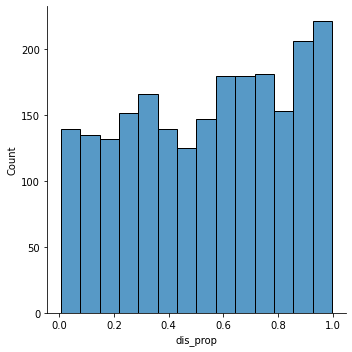

In [41]:
import seaborn as sns

ax = sns.displot(x='dis_prop',  data=event_dis_stat)
#_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


In [44]:
cryptic = pd.read_csv('/Users/zluo/CrypticSplicing/Data/ENCODE_res/HepG2_cryptic_merged.bed', sep='\t', names=['chrom','start','end','name','score','strand'])
cryptic['RBP']= cryptic['name'].str.split(':').str[0]
cryptic['gene_id'] = cryptic['name'].str.split(':').str[1]

cryptic_ETF1 = cryptic[cryptic['RBP']=='ETF1']
cryptic_ETF1
cryptic_HNRNPC = cryptic[cryptic['RBP']=='HNRNPC']
cryptic_HNRNPC

cryptic_MAGOH = cryptic[cryptic['RBP']=='MAGOH']
cryptic_MAGOH

,chrom,start,end,name,score,strand,RBP,gene_id
3740,chr1,94455732,94455804,MAGOH:ENSG00000117528.13,0.309:0.118,+,MAGOH,ENSG00000117528.13
3741,chr1,144960337,144960398,MAGOH:ENSG00000196369.11,0.116:0.198,-,MAGOH,ENSG00000196369.11
3742,chr1,10519802,10521607,MAGOH:ENSG00000142655.13,1.0:0.704,+,MAGOH,ENSG00000142655.13
3743,chr1,1848460,1848529,MAGOH:ENSG00000078369.18,0.286:1.0,-,MAGOH,ENSG00000078369.18
3744,chr1,1847877,1848036,MAGOH:ENSG00000078369.18,0.356:1.0,-,MAGOH,ENSG00000078369.18
...,...,...,...,...,...,...,...,...
3999,chr22,31176261,31176417,MAGOH:ENSG00000138942.16,0.272:0.126,+,MAGOH,ENSG00000138942.16
4000,chr22,19351071,19351256,MAGOH:ENSG00000100084.14,0.134:0.114,-,MAGOH,ENSG00000100084.14
4001,chr22,17662898,17663013,MAGOH:ENSG00000099968.17,0.167:0.0784,+,MAGOH,ENSG00000099968.17
4002,chrX,54936164,54936360,MAGOH:ENSG00000158571.10,0.203:0.273,-,MAGOH,ENSG00000158571.10


(109, 4)

<AxesSubplot:ylabel='log2fc'>

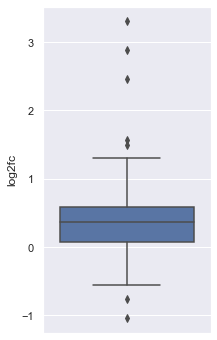

In [63]:
ETF1_kd_exp = pd.read_csv('/Users/zluo/Downloads/ENCFF181CCT.tsv',sep='\t')
ETF1_kd_exp = ETF1_kd_exp[ETF1_kd_exp['gene_id'].isin(cryptic_ETF1['gene_id'])]

ETF1_ctrl_exp = pd.read_csv('/Users/zluo/Downloads/ENCFF878EDX.tsv',sep='\t')
ETF1_ctrl_exp = ETF1_ctrl_exp[ETF1_ctrl_exp['gene_id'].isin(cryptic_ETF1['gene_id'])]
ETF1_kd_exp = ETF1_kd_exp[['gene_id','FPKM']]
ETF1_ctrl_exp = ETF1_ctrl_exp[['gene_id','FPKM']]
ETF1_exp = pd.merge(ETF1_ctrl_exp,ETF1_kd_exp, on='gene_id',suffixes=['_ctrl','_kd'])
ETF1_exp['log2fc'] = np.log2(ETF1_exp['FPKM_kd'] / ETF1_exp['FPKM_ctrl'])
ETF1_exp.shape
sns.boxplot(y='log2fc',data=ETF1_exp)
plt.savefig('/Users/zluo/TestData/ETF1_exp.pdf')

(97, 4)

<AxesSubplot:ylabel='log2fc'>

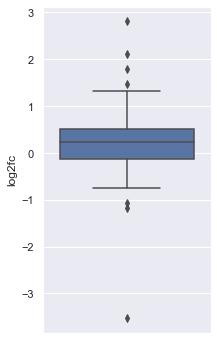

In [62]:
HNRNPC_kd_exp = pd.read_csv('/Users/zluo/Downloads/ENCFF973MZG.tsv',sep='\t')
HNRNPC_kd_exp = HNRNPC_kd_exp[HNRNPC_kd_exp['gene_id'].isin(cryptic_HNRNPC['gene_id'])]

HNRNPC_ctrl_exp = pd.read_csv('/Users/zluo/Downloads/ENCFF704NAC.tsv',sep='\t')
HNRNPC_ctrl_exp = HNRNPC_ctrl_exp[HNRNPC_ctrl_exp['gene_id'].isin(cryptic_HNRNPC['gene_id'])]

HNRNPC_kd_exp = HNRNPC_kd_exp[['gene_id','FPKM']]
HNRNPC_ctrl_exp = HNRNPC_ctrl_exp[['gene_id','FPKM']]
HNRNPC_exp = pd.merge(HNRNPC_ctrl_exp,HNRNPC_kd_exp, on='gene_id',suffixes=['_ctrl','_kd'])
HNRNPC_exp['log2fc'] = np.log2(HNRNPC_exp['FPKM_kd'] / HNRNPC_exp['FPKM_ctrl'])
HNRNPC_exp.shape
sns.boxplot(y='log2fc',data=HNRNPC_exp)
plt.savefig('/Users/zluo/TestData/HNRNPC_exp.pdf')

(84, 4)

<AxesSubplot:ylabel='log2fc'>

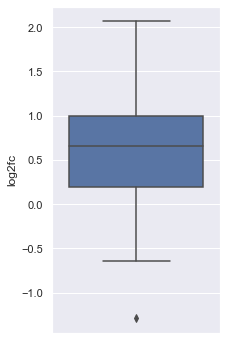

In [61]:
MAGOH_kd_exp = pd.read_csv('/Users/zluo/Downloads/ENCFF120KPF.tsv',sep='\t')
MAGOH_kd_exp = MAGOH_kd_exp[MAGOH_kd_exp['gene_id'].isin(cryptic_MAGOH['gene_id'])]

MAGOH_ctrl_exp = pd.read_csv('/Users/zluo/Downloads/ENCFF548ZDN.tsv',sep='\t')
MAGOH_ctrl_exp = MAGOH_ctrl_exp[MAGOH_ctrl_exp['gene_id'].isin(cryptic_MAGOH['gene_id'])]

MAGOH_kd_exp = MAGOH_kd_exp[['gene_id','FPKM']]
MAGOH_ctrl_exp = MAGOH_ctrl_exp[['gene_id','FPKM']]
MAGOH_exp = pd.merge(MAGOH_ctrl_exp,MAGOH_kd_exp, on='gene_id',suffixes=['_ctrl','_kd'])
MAGOH_exp['log2fc'] = np.log2(MAGOH_exp['FPKM_kd'] / MAGOH_exp['FPKM_ctrl'])
MAGOH_exp.shape
sns.boxplot(y='log2fc',data=MAGOH_exp)


[Text(0.5, 0, 'RBP'), Text(0, 0.5, 'log2FC(KD/Ctrl)')]

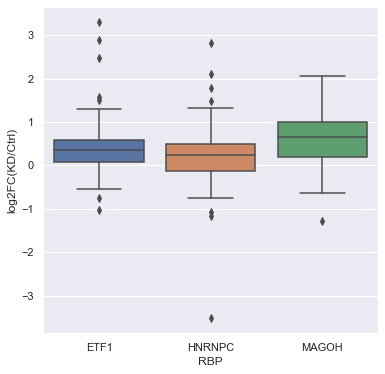

In [71]:
ETF1_exp['type'] = 'ETF1'
HNRNPC_exp['type'] = 'HNRNPC'
MAGOH_exp['type'] = 'MAGOH'
exp = pd.concat([ETF1_exp,HNRNPC_exp,MAGOH_exp])
sns.set(rc={'figure.figsize':(6,6)})
ax = sns.boxplot(x='type',y='log2fc',data=exp)
ax.set(xlabel='RBP', ylabel='log2FC(KD/Ctrl)')
plt.savefig('/Users/zluo/TestData/Exp.pdf')

In [3]:
gtf_gene, gtf_ts, gtf_exon, gtf_CDS = utils.parse_gtf("../TestData/GENCODE/mm10/gencode.vM25.primary_assembly.annotation.gtf")

Dask Apply:   0%|          | 0/24 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/24 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/24 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/24 [00:00<?, ?it/s]

In [8]:
gtf_gene_coding = gtf_gene[gtf_gene['gene_type'] == 'protein_coding']
gtf_gene_coding['gene_id'] = gtf_gene_coding['gene_id'].str.split('.').str[0]
gtf_gene_coding.to_csv('/Users/zluo/TestData/GENCODE/mm10/gencode.vM25.primary_assembly.annotation.gene.coding.tab',sep='\t',index=False)

/Users/zluo/miniconda/envs/defcomp/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [4]:
tx2gene = gtf_ts[['transcript_id', 'gene_id']]
tx2gene.to_csv('/Users/zluo/TestData/GENCODE/mm10/gencode.vM25.tx2gene.tab',sep='\t',index=False)
gene_id2symbol = gtf_ts[['gene_id', 'gene_name']]
gene_id2symbol.to_csv('/Users/zluo/TestData/GENCODE/mm10/gencode.vM25.gene_symbol.tab',sep='\t',index=False)

In [14]:
Go_file_sets = ['/Users/zluo/YizhenTang/DAVID_FAC_SPF_vs_SPF-LPS.txt',
                '/Users/zluo/YizhenTang/DAVID_FAC_UP_SPF_vs_SPF-LPS.txt',
                '/Users/zluo/YizhenTang/DAVID_FAC_DN_SPF_vs_SPF-LPS.txt',
                #'/Users/zluo/YizhenTang/DAVID_FAC_GF_vs_GF-LPS.txt',
                '/Users/zluo/YizhenTang/DAVID_FAC_GF_vs_SPF.txt',
                '/Users/zluo/YizhenTang/DAVID_FAC_UP_GF_vs_SPF.txt',
                '/Users/zluo/YizhenTang/DAVID_FAC_DN_GF_vs_SPF.txt',
                '/Users/zluo/YizhenTang/DAVID_FAC_GF-LPS_vs_SPF-LPS.txt',
                '/Users/zluo/YizhenTang/DAVID_FAC_UP_GF-LPS_vs_SPF-LPS.txt',
                '/Users/zluo/YizhenTang/DAVID_FAC_DN_GF-LPS_vs_SPF-LPS.txt']
for Go_file in Go_file_sets:
    GO = pd.read_csv(Go_file,sep='\t')
    GO['CTerm'] = ' '
    term = GO[GO['Category']=='KEGG_PATHWAY']['Term'].str.split(':').str[1]
    GO.loc[GO['Category']=='KEGG_PATHWAY','CTerm'] = term
    term = GO[GO['Category']=='KEGG']['Term'].str.split(':').str[1]
    #print(term)
    GO.loc[GO['Category']=='KEGG','CTerm'] = term
    term = GO[GO['Category']!='KEGG_PATHWAY']['Term'].str.split('~').str[1]
    GO.loc[GO['Category']!='KEGG_PATHWAY','CTerm'] = term
    GO.loc[GO['Category']=='KEGG_PATHWAY','Category'] = 'KEGG'
    GO.loc[GO['Category']=='GOTERM_CC_FAT','Category'] = 'GO:CC'
    GO.loc[GO['Category']=='GOTERM_MF_FAT','Category'] = 'GO:MF'
    GO.loc[GO['Category']=='GOTERM_BP_FAT','Category'] = 'GO:BP'
    GO.to_csv(Go_file,sep='\t',index=False)

In [39]:
import datetime
month_1st_monday = {}

for year in range(1,2022):
    cnt = 0
    month_list = []
    for month in range(1,13):
        if datetime.date(year,month,2).weekday() ==1:
            cnt +=1
            month_list.append(month)
    month_1st_monday[year] = [cnt,month_list]

month_1st_monday = sorted(month_1st_monday.items(), key=lambda x: x[1], reverse=True)        

In [1]:
month_1st_monday

NameError: name 'month_1st_monday' is not defined